In [8]:
import torch as th
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch import nn
import pandas as pd
import numpy as np
import tqdm
from src.model import SharedBilinearDecoder, SimpleGCMC, Discriminator
from src.dataset import CustomDataset
from src.dataloader import load_ML100K

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

device = 'cuda' if th.cuda.is_available() else 'cpu'

In [9]:
train_ratings,test_ratings,users_df,movies_df = load_ML100K('./data/ml-100k/')

y_true=np.ascontiguousarray(users_df['gender'].apply(lambda x: 0 if x == 'M' else 1))
users=np.asarray(list(set(users_df['user_id'])))

num_entities = len(users)

cutoff = int(np.round(len(users)*.8))
train_users = users[:cutoff]
test_users = users[cutoff:]

user_train_set = CustomDataset(train_users)
user_test_set = CustomDataset(test_users)

In [10]:
def optimizer(name:str, parameters):
    if name == "adam":
        return th.optim.Adam(params=parameters)
    else:
        raise Exception(f'Optimizer {name} has not been added yet')

        
def activation(name:str):
    if name == 'sigmoid':
       return nn.Sigmoid() 

    else:
        raise Exception(f'Activation function {name} has not been added yet')

        
def criterion(name:str):
    if name == 'BCELoss':
        return nn.BCELoss()
    else:
        raise Exception(f'Criterion function {name} has not been added yet')
    
def roc_auc(y, y_hat, name:str=None):
    if name=='multi':
        y = np.asarray(y).squeeze()
        y_hat = np.asarray(y_hat).squeeze()
        lb = LabelBinarizer()
        lb.fit(y)
        y = lb.transform(y)
        return roc_auc_score(y, y_hat, average='multi')
    else:
        return roc_auc_score(y, y_hat)

In [26]:
# AutoEncoder Model Parameters
NUM_REL=5
NUM_WEIGHTS=2
HID_DIM=32
P=1

# Discriminator Parameters
ACTIVATION = 'sigmoid'
OPTIMIZER = 'adam'
CRITERION = 'BCELoss'
OUT_DIM=1

#Training Parameters
EPOCHS = 100
BATCH_SIZE=512
NUM_WORKERS=1

# SBD_decoder = SharedBilinearDecoder(num_relations=NUM_REL,num_weights=NUM_WEIGHTS, embed_dim=HID_DIM).to(device)
# autoencoder = SimpleGCMC(decoder=SBD_decoder, embed_dim=HID_DIM, num_ent=num_entities, p=P)
discriminator=Discriminator(hidden_dim = HID_DIM, out_dim=OUT_DIM, activation=activation(ACTIVATION))
train_loader = DataLoader(user_train_set, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)
test_loader = DataLoader(user_test_set, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)
loss_fn = criterion(CRITERION)
opt = optimizer(OPTIMIZER,discriminator.parameters())

In [27]:
class Encoder(nn.Module):
    """
    This is the Encoder model fr
    - this is used to provide discriminators with vectorized user embeddings. 
    - the discriminating models then predict a sensitive user attribute given the output embeddings
    
    Note:
    this model does not require any additional decoding models. There is already a prebuilt decoder model (SharedBilinearDecoder)
    """
    def __init__(self, hidden_dim, num_ent):
        super(Encoder, self).__init__()       
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        r = 6 / np.sqrt(hidden_dim)
        self.encoder = nn.Embedding(num_ent, hidden_dim)
        self.encoder.weight.data.uniform_(-r, r).renorm_(p=2, dim=1, maxnorm=1)

    def forward(self, nodes, filters=None):
        embs = self.encoder(nodes)
        embs = self.batchnorm(embs)
        
        return embs

In [28]:
usermodel=Encoder(hidden_dim=32, num_ent=num_entities)


In [29]:
def test_discriminator(test_loader, encoder,discriminator, y_true):
    probs_list, labels_list = [], []
    for p_batch in test_loader:
        p_batch_var = Variable(p_batch).to(device)
        p_batch_emb = usermodel(p_batch_var.detach())
        y_hat = discriminator(p_batch_emb)
        y = Variable(th.FloatTensor(y_true[p_batch_var.cpu()])).to(device)
        probs_list.append(y_hat)
        labels_list.append(y)

    Y = th.cat(labels_list,0)
    Y_hat = th.cat(probs_list,0)
    loss = loss_fn(Y_hat,Y)
    auc = roc_auc(Y.data.cpu().numpy(), Y_hat.data.cpu().numpy())
    return loss, auc


In [31]:
usermodel.eval()
dataloader=tqdm.tqdm(range(1, EPOCHS+1))
train_loss_vals, test_loss_vals = [], []
train_auc_vals, test_auc_vals = [], []
for epoch in dataloader:
    probs_list, labels_list = [], []
    for p_batch in train_loader:
        p_batch_var = Variable(p_batch).to(device)
        p_batch_emb = usermodel(p_batch_var.detach()) 
        y_hat = discriminator(p_batch_emb)
        y = Variable(th.FloatTensor(y_true[p_batch_var.cpu()])).to(device)
        probs_list.append(y_hat)
        labels_list.append(y)
        loss = loss_fn(y_hat,y)

        opt.zero_grad()
        loss.backward()
        opt.step()

    Y = th.cat(labels_list,0)
    Y_hat = th.cat(probs_list,0)
    train_auc = roc_auc(Y.data.cpu().numpy(), Y_hat.data.cpu().numpy())
    train_loss = loss_fn(Y_hat, Y)

    test_loss, test_auc = test_discriminator(test_loader, usermodel, discriminator, y_true)
    
    train_loss_vals.append(train_loss.item())
    test_loss_vals.append(test_loss.item())
    
    train_auc_vals.append(train_auc.item())
    test_auc_vals.append(test_auc.item())
    
    # dataloader.set_description(f'Train Loss: {train_loss}, Train AUC: {train_auc}, Test Loss: {test_loss}, Test AUC: {test_auc}')

100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


/home/charles.cochran/Dev/prefair-fairness/.env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


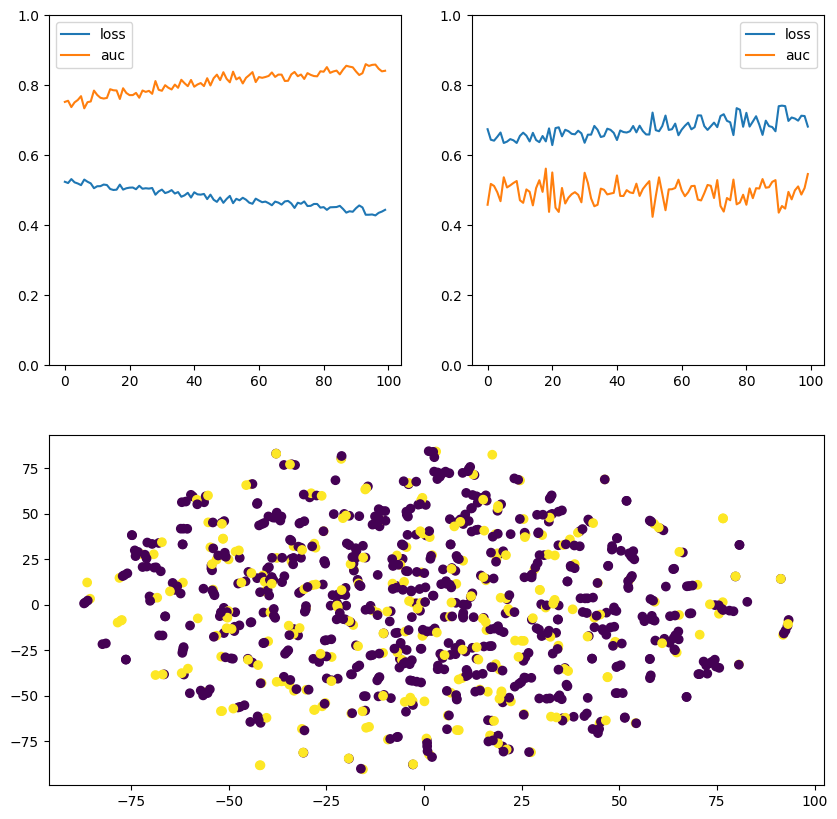

In [33]:
fig = plt.figure(figsize=(10,10))
train_ax = plt.subplot(221)
test_ax = plt.subplot(222)
emb_ax = plt.subplot(212)
train_ax.plot(list(range(EPOCHS)), train_loss_vals, label='loss')
train_ax.plot(list(range(EPOCHS)), train_auc_vals, label='auc')
train_ax.set_ylim(0,1)
train_ax.legend()
test_ax.plot(list(range(EPOCHS)), test_loss_vals, label='loss')
test_ax.plot(list(range(EPOCHS)), test_auc_vals, label='auc')
test_ax.set_ylim(0,1)
test_ax.legend()
user_embs = usermodel(th.tensor(users)).detach()
data = TSNE(n_components=2, init='random', perplexity=3).fit_transform(user_embs)
emb_ax.scatter(data[:,0],data[:,1], c=y_true)
plt.show()